# Keras deep neural network tuned with Bayesian optmization with SMAC

This notebook aims to demonstrate on training and tuning deep neural networks using Bayesian optmization. The example problem used in the notebook is a binary classification problem. We use Keras (with Tensorflow backend) as a library to develop neural network models and SMAC for Bayesian optmization library. In particular, the notebook performs the following.
* Create a sample binary-classification dataset that is imbalanced (ratio = 1:9)
* Split the dataset into training, test, and validation set
* Execute oversampling on the training set
* Develop example a parameterized deep learning model based on Keras Sequential model
* Focus on 5 parameters: learning rate, drop out rate, number of layers, number of hidden units, number of epoch


In [32]:
#!/usr/bin/env python
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import metrics
import tensorflow as tf
%matplotlib inline  
import keras
import smac

USE_RESAMPLING = True

Create an example binary-classification dataset from Sklearn API

In [2]:
from sklearn.datasets import make_classification
x_raw, y_raw = make_classification( n_samples=50000,   n_features=70,
                                    n_informative=10, n_redundant=60,
                                    random_state=42, weights={0:1.8, 1:1})

Investigate on how imbalanced it is

In [3]:
np.bincount(y_raw)

array([44789,  5211])

In [4]:
X_pd = pd.DataFrame(x_raw)
Y_pd = pd.DataFrame(y_raw)

Split the dataset into 2 parts

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pd, Y_pd, test_size=0.20,
                                                    random_state=42)

In [6]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(40000, 70)
(40000, 1)
(10000, 70)
(10000, 1)


In [7]:
Y_test.iloc[:, 0].value_counts()

0    8912
1    1088
Name: 0, dtype: int64

# Add oversampling here to only the training set

In [8]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

if USE_RESAMPLING:
    target_num_samples_major = Y_train[Y_train == 1].shape[0]
    sampling_model = SMOTE()

    X_resampled_train, Y_resampled_train = sampling_model.fit_sample(X_train, Y_train)
    X_train = pd.DataFrame(X_resampled_train, columns=X_pd.columns)
    Y_train = pd.DataFrame(Y_resampled_train)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
Y_train.iloc[:,0].value_counts()

1    35877
0    35877
Name: 0, dtype: int64

In [10]:
Y_test.iloc[:,0].value_counts()

0    8912
1    1088
Name: 0, dtype: int64

In [11]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(Y_train.values.reshape(-1, 1))
Y_train_encoded = enc.transform(Y_train.values.reshape(-1, 1)).toarray()
Y_test_encoded  = enc.transform(Y_test.values.reshape(-1, 1)).toarray()
Y_train_encoded

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [12]:
num_samples = X_train.shape[0]
num_features = X_train.shape[1]

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import SGD, Adam
from sklearn.metrics import roc_auc_score

In [14]:
batch_size = 32

Evaluation function

In [15]:
def eval_results(model, X, Y):
    predict_probs = model.predict(X, batch_size=batch_size)
    Y_prob_score = predict_probs[:,1]
    
    return roc_auc_score(Y, Y_prob_score)

# Wrap the evaluation function entirely inside a function

In [16]:
def model_architecture(learning_rate, num_layers, hidden_units, dropout_rate, num_epoch):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_dim=num_features))
    
    for _ in range(num_layers - 1):
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization(axis=-1, momentum=0.99, 
                                     epsilon=0.001, center=True, scale=True, 
                                     beta_initializer='zeros', gamma_initializer='ones'))

    # Add head at the end to be a softmax layer (Binary classification)
    model.add(Dense(2, activation='softmax'))

    adam = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    return model

Parser to extract model parameters from configuration dictionary

In [17]:
def get_model_from_cfg(cfg):
    learning_rate = cfg["learning_rate"]
    dropout_rate  = cfg["dropout_rate"]
    num_layers    = cfg["num_layers"]
    hidden_units  = cfg["hidden_units"]
    num_epoch     = cfg["num_epoch"]
    
    print(""" Learning rate = %.5f, num_layers = %s, hidden_units = %s, dropout_rate = %s, num_epoch = %s    """
          % ( learning_rate, num_layers, hidden_units, dropout_rate,  num_epoch)         
         )
    return model_architecture(learning_rate=learning_rate,
                              num_layers=num_layers,
                              hidden_units=hidden_units,
                              dropout_rate=dropout_rate,
                              num_epoch=num_epoch)

* Wrap a full K-fold validation inside a single function

In [18]:
nfold = 2
def fit_dnn_from_cfg(cfg):
    """ Evaluate DNN based on the configuration
    Parameter: cfg dictionary 
    Returns:
    --------
    A cross validated score
    """
    model = get_model_from_cfg(cfg)
    num_epoch = cfg["num_epoch"]
    scores = np.zeros(nfold)
    for n in range(nfold):
        idx = np.array(range(X_train.shape[0]))
        idx_valid = np.logical_and(idx>=X_train.shape[0]/nfold*n, idx<X_train.shape[0]/nfold*(n+1))
        idx_train = np.logical_not(idx_valid)
        model.fit(X_train.values[idx_train,:], Y_train_encoded[idx_train,:], 
                  epochs=num_epoch, batch_size=batch_size, shuffle=True,
                  callbacks = None, verbose=1)
        scores[n] = eval_results(model, X_train.values[idx_valid, :], Y_train_encoded[idx_valid, 1])
    cross_val_auc = sum(scores)/nfold
    print(" Got cross validated score = %s, each fold score is %s" % (cross_val_auc, str(scores)))
    return 1 - cross_val_auc # We want to maximize cross-validated AUC (which is equivalent to minize 1 - fs

Import SMAC library and classes

In [19]:
import smac

# Import ConfigSpace and different types of parameters
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter

# Import SMAC-utilities
from smac.tae.execute_func import ExecuteTAFuncDict
from smac.scenario.scenario import Scenario
from smac.facade.smac_facade import SMAC

In [20]:
cs = ConfigurationSpace()

In [21]:
learning_rate = UniformFloatHyperparameter("learning_rate", 1e-4, 1e-1, default=1e-3)
dropout_rate  = UniformFloatHyperparameter("dropout_rate",  0.001, 0.25, default=0.01)
num_layers    = UniformIntegerHyperparameter("num_layers",  5, 10, default=5)
hidden_units  = UniformIntegerHyperparameter("hidden_units",  5, 30, default=10)
num_epoch     = UniformIntegerHyperparameter("num_epoch",     2, 10, default=3)

cs.add_hyperparameters([learning_rate, dropout_rate, num_layers, hidden_units, num_epoch])

[learning_rate, Type: UniformFloat, Range: [0.0001, 0.1], Default: 0.001,
 dropout_rate, Type: UniformFloat, Range: [0.001, 0.25], Default: 0.01,
 num_layers, Type: UniformInteger, Range: [5, 10], Default: 5,
 hidden_units, Type: UniformInteger, Range: [5, 30], Default: 10,
 num_epoch, Type: UniformInteger, Range: [2, 10], Default: 3]

In [22]:
# Scenario object
scenario = Scenario({"run_obj": "quality",   # we optimize quality (alternatively runtime)
                     "runcount-limit": 5,  # maximum function evaluations
                     "cs": cs,               # configuration space
                     "deterministic": "true"
                     })

In [23]:
print("Optimizing! Depending on your machine, this might take a few minutes.")
smac = SMAC(scenario=scenario, rng=np.random.RandomState(42),
        tae_runner=fit_dnn_from_cfg)

optimized_cfg = smac.optimize()



Optimizing! Depending on your machine, this might take a few minutes.
 Learning rate = 0.00100, num_layers = 5, hidden_units = 10, dropout_rate = 0.01, num_epoch = 3    
Epoch 1/3
35877/35877 [==============================] - 2s - loss: 0.2762 - acc: 0.8854     
Epoch 2/3
35877/35877 [==============================] - 2s - loss: 0.1412 - acc: 0.9446     
Epoch 3/3
35877/35877 [==============================] - 2s - loss: 0.1176 - acc: 0.9528     
Epoch 1/3
35877/35877 [==============================] - 2s - loss: 0.3100 - acc: 0.9192     
Epoch 2/3
35877/35877 [==============================] - 2s - loss: 0.0969 - acc: 0.9701     
Epoch 3/3
35877/35877 [==============================] - 2s - loss: 0.0813 - acc: 0.9777     
 Got cross validated score = 0.975573058056, each fold score is [ 0.97116134  0.97998477]
 Learning rate = 0.09412, num_layers = 8, hidden_units = 28, dropout_rate = 0.004292986996289652, num_epoch = 8    
Epoch 1/8
35877/35877 [==============================] - 3s 

# Obtained parameters during the search process

Best parameters was

In [24]:
optimized_cfg

Configuration:
  dropout_rate, Value: 0.007277670988809294
  hidden_units, Value: 17
  learning_rate, Value: 0.0359092931164673
  num_epoch, Value: 7
  num_layers, Value: 8

Best cost was (1 - AUC)

In [25]:
incumbent_value = fit_dnn_from_cfg(optimized_cfg)
print("Optimized Value: %.2f" % (incumbent_value))

 Learning rate = 0.03591, num_layers = 8, hidden_units = 17, dropout_rate = 0.007277670988809294, num_epoch = 7    
Epoch 1/7
35877/35877 [==============================] - 3s - loss: 0.1656 - acc: 0.9289     
Epoch 2/7
35877/35877 [==============================] - 3s - loss: 0.1312 - acc: 0.9407     
Epoch 3/7
35877/35877 [==============================] - 3s - loss: 0.1160 - acc: 0.9486     
Epoch 4/7
35877/35877 [==============================] - 3s - loss: 0.1115 - acc: 0.9508     
Epoch 5/7
35877/35877 [==============================] - 3s - loss: 0.1082 - acc: 0.9537     
Epoch 6/7
35877/35877 [==============================] - 3s - loss: 0.1099 - acc: 0.9524     
Epoch 7/7
35877/35877 [==============================] - 3s - loss: 0.1074 - acc: 0.9536     
Epoch 1/7
35877/35877 [==============================] - 3s - loss: 0.1253 - acc: 0.9666     
Epoch 2/7
35877/35877 [==============================] - 3s - loss: 0.0870 - acc: 0.9768     
Epoch 3/7
35877/35877 [===============

# Test the parameters on model

Obtained the searched parameter

In [26]:
model = get_model_from_cfg(optimized_cfg)

 Learning rate = 0.03591, num_layers = 8, hidden_units = 17, dropout_rate = 0.007277670988809294, num_epoch = 7    


In [27]:
num_epoch = optimized_cfg["num_epoch"]
num_epoch

7

Trained the model for the whole training dataset

In [28]:
model.fit(X_train.values, Y_train_encoded, 
                      epochs=num_epoch, batch_size=batch_size, shuffle=True,
                      callbacks = None, verbose=1)

Epoch 1/7
71754/71754 [==============================] - 8s - loss: 0.1916 - acc: 0.9379     
Epoch 2/7
71754/71754 [==============================] - 8s - loss: 0.1515 - acc: 0.9569     
Epoch 3/7
71754/71754 [==============================] - 8s - loss: 0.1467 - acc: 0.9594     
Epoch 4/7
71754/71754 [==============================] - 7s - loss: 0.1359 - acc: 0.9642     
Epoch 5/7
71754/71754 [==============================] - 7s - loss: 0.1317 - acc: 0.9664     
Epoch 6/7
71754/71754 [==============================] - 8s - loss: 0.1272 - acc: 0.9675     
Epoch 7/7
71754/71754 [==============================] - 7s - loss: 0.1278 - acc: 0.9668     


# Test on the test set

In [29]:
eval_results(model, X_test.values, Y_test)

0.98292794662187133

In [35]:
def visualize_ROC_curve(Y_predict_prob):
    fpr, tpr, _ = metrics.roc_curve(Y_test, Y_predict_prob)
    roc_auc  =    metrics.roc_auc_score(Y_test, Y_predict_prob)
    plt.figure(figsize=(20,15))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC curve)', fontsize=30)
    plt.legend(loc="lower right")
    plt.rc('xtick', labelsize=30)
    plt.rc('ytick', labelsize=30) 
    plt.rc('legend', fontsize=30) 
    plt.rc('axes', labelsize=30) 

    plt.show()


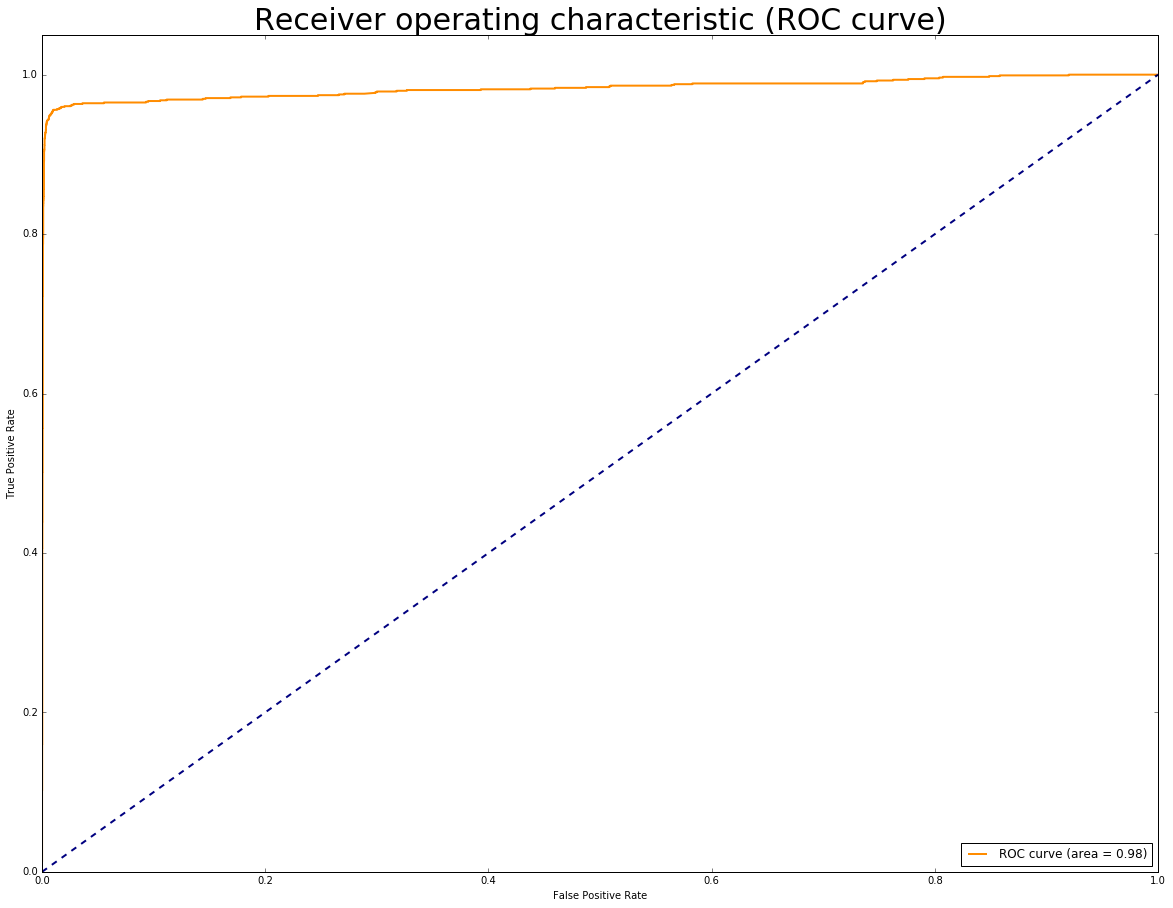

In [36]:
predict_probs = model.predict(X_test.values, batch_size=batch_size)
visualize_ROC_curve(predict_probs[:,1])